In [1]:
import numpy as np
from numpy import newaxis as NA
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sigma, epsilon = 3.401, 0.997

# Solving nonlinear eq. in 1D

# a. Lennard Jones Energy 

In [2]:
def plot_func(x1, y1, figsize = (10,5), label1="", xlabel="", ylabel="", title="",
              x2=0, y2=0, label2="", plot2 = False, legend = False, plot3=False,
             x3=0, y3=0, label3 = ""):
    fig, ax = plt.subplots()
    ax.plot(x1, y1, label = label1)
    if plot2:
        ax.plot(x2, y2, label = label2)
    if plot3:
        ax.plot(x3,y3,label = label3)
    ax.set_ylabel(ylabel, fontsize = 15), ax.set_xlabel(xlabel, fontsize = 15)
    if legend:
        ax.legend(fontsize = 15)
    ax.set_title(title, fontsize = 15)
    plt.show()

In [3]:
def distance(points):
    """Calculates Euclidean distance between N points. points is an Nx3 array."""
    displacement = points[:,NA]-points[NA,:] #(N,N,3) displacement vector
    return np.sqrt(np.sum(displacement*displacement , axis=-1))

In [4]:
def div_0(a,b): 
    """Divides a by b. If b==0 returns 0."""
    return np.divide(a, b, out=np.zeros_like(b), where=b!=0)

In [5]:
def LJ(sigma, epsilon):
    """Creates the function V which computes the LJ potential with specified\
    sigma and epsilon."""
    def V(points):
        """Returns the Energy of N particle system given coordinates (Nx3) in the\
        Lennard Jones potential."""
        r = distance(points)
        N = len(r)
        #take only upper triangular part of the matrix since dist(ij)=dist(ji)
        r = np.triu(r)
        return np.sum(4*epsilon*((div_0(sigma,r))**12-(div_0(sigma,r))**6))
    return V

In [6]:
N = 500
range0 = np.linspace(3,11,N)
Points = np.zeros((N,4,3))
Points[:,0,0], Points[:,2,0] = range0, 14
Points[:,3,[0,1]] = [7,3.2]
E2, E4 = np.empty(shape = N), np.empty(shape = N)
V = LJ(sigma, epsilon)
for i in range(N): #Computing LJ energy for N coordinates
    E2[i] = V(Points[i,:2,:])
    E4[i] = V(Points[i,:,:])

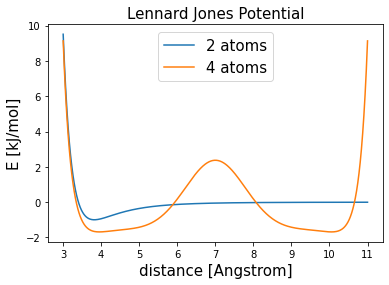

In [7]:
plot_func(range0,E2,figsize = (10,5),label1="2 atoms",xlabel="distance [Angstrom]",
          ylabel="E [kJ/mol]",title="Lennard Jones Potential",x2=range0,y2=E4,label2="4 atoms",
          plot2 = True, legend = True)

# b. Bisection Method

In [8]:
def bis(f,a,b,tol, max_iter = 1000):
    """Bisection method for finding roots of a funciton f given an interval [a,b]
    where sign(f(a))!=sign(f(b)).\nReturns: Root x within the given tolerance 
    number of function calls n_calls."""
    fa, fb = f(a), f(b)
    assert(np.sign(fa)!=np.sign(fb))
    n_calls = int(np.ceil(np.log2((b-a)/tol)))
    if max_iter < n_calls: 
        n_calls = max_iter
    x = (a+b)/2
    for i in range(n_calls):
        fx = f(x)
        if np.sign(fx)==np.sign(fa):
            a = x
        else:
            b = x
        x = (a+b)/2
    return x, n_calls+2

In [9]:
def Vx(x):
    """Helper function to call V with a range of different x in the 1d case."""
    return V(np.array([np.zeros(3), np.array([0,0,x])]))

x_root,n = bis(Vx,2,6,5e-14)
print("x_root = {:3.4}\n\
V(x_root) = {:3.2e}".format(x_root, Vx(x_root)))

x_root = 3.401
V(x_root) = 2.66e-14


To get $|f(X)|<10^{-13}$ 49 function calls were needed.

# c. Newton Raphson method

In [10]:
def DV(r,sigma = sigma, epsilon = epsilon):
    """Derivative of the Lennard-Jones potential."""
    return 4*epsilon*(6*sigma**6/r**7 - 12*sigma**12/r**13)

In [11]:
def newton_root(f, df, x0, tol, max_iter):
    """Newton-Rhapson method to find root of a function f.\nReturns:
    root of f x0 within tolerance or last computed x0 if n_calls reaches max_iterations
    number of function calls n_calls."""
    f0 = f(x0)
    n_calls = 1
    while (abs(f0)>tol) and (n_calls<max_iter):
        n_calls+=2
        x0 = x0-f0/df(x0)
        f0 = f(x0)
    return x0, n_calls
x_newton, n_calls = newton_root(Vx, DV, 2, 1e-12,100)
print("Newton method results in:\nx_root = {:3.4}\n\
V(x_root) = {:3.2e}".format(x_newton, Vx(x_newton)))

Newton method results in:
x_root = 3.401
V(x_root) = 1.06e-14


To get $|f(X)|<10^{-12}$ 25 function calls were needed. 

# d. Combination of NR and bisection method 

In [12]:
def NR_bis(f, df, a, b, x0, tolerance):
    """Root finding using a combination of Newton Rhapson and bisection
    which guarantees convergence.\n Returns:\n root x0\n number of function calls n_calls"""
    f0 = f(x0)
    n_calls = 1
    while abs(f0)>tolerance:
        n_calls += 1
        xn = x0-f0/df(x0) #if new point is outside of [a,b] execute bisection
        if ((xn<a) or (xn>b)):
            n_calls+=2
            fa = f(a)
            x0 = (a+b)/2
            f0 = f(x0)
            if np.sign(f0)==np.sign(fa):
                a = x0
            else:
                b = x0
        else:
            x0 = xn
            n_calls += 1
            f0 = f(x0)
    return x0, n_calls

x0, n_calls = NR_bis(Vx, DV, 2, 4, 2, tolerance=1e-13)
print("The combination of Newton method and bisection results in:\nx_root = {:3.4}\n\
V(x_root) = {:3.2e}".format(x0, Vx(x0)))

The combination of Newton method and bisection results in:
x_root = 3.401
V(x_root) = 1.06e-14


To get $|f(X)|<10^{-13}$ 25 function calls were needed. 

# Solving Nonlinear equations in N dimensions

# e. 

In [13]:
def LJgradient(sigma, epsilon):
        """Returns: derivative of LJ potential gradV(X) with given sigma and epsilon."""
        def gradV(X):
            """Given an the coordinates of N points in an (N,3) array \nreturns:
            gradient in the 3N dimensional space."""
            d = X[:,NA]-X[NA,:] #(N,N,3) displacement vector
            r = np.sqrt(np.sum(d**2, axis=-1)) #(N,N) distances
            np.fill_diagonal(r,1)
            T = 6*sigma**6/(r**7) - 12*sigma**12/(r**13) # (N,N) derivatives matrix
            u = d/r[:,:,NA] #u is (N,N,3) array of unit vectors in dir Xi-Xj
            return 4*epsilon*np.sum(T[:,:,NA]*u, axis = 1)
        return gradV
gradV = LJgradient(sigma,epsilon)

In [14]:
def Fx(x,f):
    """Helper function, compute function F: R^3->R on a 1d subspace."""
    return f(np.array([np.zeros(3), np.array([0,0,x])]))

In [15]:
range1 = np.linspace(3,10,N)
gradient = np.empty(shape = (N,2,3))
for i in range(N):
    gradient[i] = Fx(range1[i],gradV)

Exactly two components of the gradient are nonzero since each particle experiences a force only in one dimension. The signs are equal and opposite because of Newtons 3rd law.

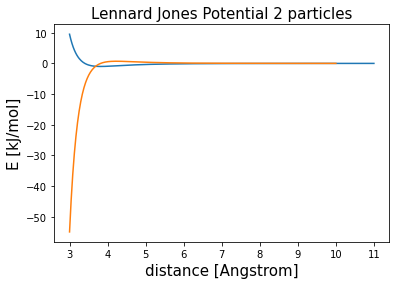

In [16]:
plot_func(range0, E2, figsize = (9,5), label1="LJ", xlabel="distance [Angstrom]",
          ylabel="E [kJ/mol]", title="Lennard Jones Potential 2 particles", x2=range1,
          y2=gradient[:,1,2], label2 = "gradLJ",plot2 = True)

In [17]:
print("Gradient in the minimum of the plot,\
which was computed along x direction:\n{}".format(gradV(Points[np.argmin(E4)])))

Gradient in the minimum of the plot,which was computed along x direction:
[[-0.00870944 -0.47436174  0.        ]
 [-0.46866508 -0.00947811  0.        ]
 [ 0.02463949 -0.00947811  0.        ]
 [ 0.45273503  0.49331796  0.        ]]


One can see that for this arrangement of 4 points the gradient is not zero even though the minimum along the x direction was chosen. The points are arranged in 2d with a fixed y component. The minimum which leads to a vanishing gradient requires has therefore to be found in 2d.

# f. Line search 

In [18]:
def linesearch(F, X0, d, alpha_max, tol, max_iter):
    """Returns: X = X0+alpha*d such that d@F(X)=0 within tolerance tol or X that
    was computed in the last step once max_iter is reached.\n number of
    function calls."""
    F_restricted = lambda alpha: F(X0 + alpha*d).flatten()
    gradF_restricted = lambda s: d.flatten()@F_restricted(s)
    alpha, n_calls = bis(gradF_restricted, 0, alpha_max, tol, max_iter)
    return X0+alpha*d, n_calls, alpha

## Test 

In [19]:
X0 = np.zeros((4,3))
X0[:,0], X0[-1,1] = [4,0,14,7], 3.2
d = -gradV(X0)
X_min, n_calls, alpha = linesearch(gradV, X0, d, 1, 1e-12, 400)
d.flatten()@gradV(X_min).flatten(), n_calls, alpha

(-1.902866753056287e-12, 42, 0.45170705184182225)

A minimum $x_{min}$ was found with $d\cdot\nabla V(x_{min})=-1.9\cdot10^{-12}$ after 42 function calls resulting in $\alpha = 0.452$. 

# Nonlinear Optimization (Week 5) 

In [20]:
ArStart = np.load('ArStart.npz')
Xstart2 = ArStart['Xstart2']

In [21]:
def flatten_func(f): return lambda X: f(X.reshape(-1,3))
def flatten_grad(f): return lambda X: f(X.reshape(-1,3)).reshape(-1)

# g. Golden section search

In [22]:
phi = (1 + 5**0.5) / 2
def golden_section_min(f, a, b, tol = 1e-3):
    """For a strictly unimodal function on the interval [a,b], using golden section search
    Returns: \nminimum x_opt\nnumber of function calls .
    """
    n_calls = 0
    c = b - (b-a)/phi
    d = a + (b-a)/phi
    while abs(c-d)>tol:
        n_calls +=2
        if f(c) < f(d):
            b = d
        else:
            a = c
        c = b - (b - a) / phi
        d = a + (b - a) / phi
    return (b+a)/2, n_calls 

## Obtain $\alpha$ 

In [23]:
X_test = np.copy(X0)
alpha_gs, n_calls_gs = golden_section_min(lambda s: V(X_test+s*d), 0,1)
X_min_gs = X_test+alpha_gs*d
d.flatten()@gradV(X_min_gs).flatten(), n_calls, alpha_gs

(0.0038784597995839554, 42, 0.45240252875494213)

Golden section search resulted in $\alpha = 0.452$.

## Find optimal distance between 2 Ar atoms 

In [24]:
X_min_2gs, n_calls_2gs = golden_section_min(Vx, 0,10)
r0 = X_min_2gs
print("Golden section serach results in r0 = {:3.3}".format(r0))

Golden section serach results in r0 = 3.82


# h. Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm 

In [25]:
def BFGS(gradf, X, tol = 1e-6, max_iter = 10000):
    """Uses the Broyden-Fletcher-Goldfarb-Shanno algorithm which is a quasi-Newton method
    to solve nonlinear optimization problems.\nReturns:\nMinimum X\nNumber of calls N_calls
    Boolean variable converged, which is false if max_iter wa exceeded"""
    N_calls, converged = 0, True
    X = np.copy(X)
    dfX0 = gradf(X)
    np.random.seed(10)
    B = np.eye(len(X))*860
    while(abs(la.norm(dfX0))>tol and N_calls<=max_iter):
        N_calls+=2
        dx = la.solve(B,-dfX0)
        X = X + dx
        dfX = gradf(X)
        dy = dfX-dfX0
        dfX0 = dfX
        B += np.outer(dy,dy)/(dy@dx) - np.outer(B@dx, B@dx)/(dx@(B@dx))
    if N_calls>=max_iter:
        converged = False
    return X, N_calls, converged

In [26]:
V_flat, dV_flat = flatten_func(V), flatten_grad(gradV)
X_min2, calls2, conv2 = BFGS(dV_flat, Xstart2, tol = 1e-4, max_iter = 100)
r0_BFGS = la.norm(X_min2[:3]-X_min2[3:])
print("BFGS results in r0 = {:3.3}".format(r0_BFGS))

BFGS results in r0 = 3.82


# i. N-particle system 

In [27]:
def num_vdw(X):
    d = distance(X.reshape(-1,3))
    return np.sum(abs(d-r0)/r0 <= .01)

In [28]:
ArStarts = []
for key, value in ArStart.items():
    temp = [key,value]
    ArStarts.append(temp)

In [29]:
X_min_N, calls_N, conv_N, Distance_N, vdw_N, E_N = [],[],[],[],[], []
for i in range(8):
    X_min, calls, conv = BFGS(dV_flat, ArStarts[i][1], tol = 1e-10, max_iter = 30000)
    X_min_N.append(X_min), calls_N.append(calls)
    conv_N.append(conv), Distance_N.append(d)
    vdw_N.append(num_vdw(X_min))
    E_N.append(V_flat(X_min))
print("Energies: {}\nNumber of function calls = {}".format(E_N, calls_N))

Energies: [-0.9969999999999998, -2.9909999999999997, -5.981999999999999, -7.848945937589153e-12, -9.719658160297116e-10, -8.392995879772724e-10, -2.2916509114805852e-09, -2.0944094069531175e-09]
Number of function calls = [10, 70, 138, 54, 108, 182, 112, 76]


| Number of particles | 2 | 3 | 4  | 5 | 6 | 7 | 8 | 9 |
|---------------------|---|---|----|---|---|---|---|---|
| Number of VdW bonds | 2 | 6 | 12 | 0 | 0 | 0 | 0 | 0 |

The algorithm converges for all number of particles. But for $N\geq5$ there are no VdW bonds between particles. As the LJ potential gets flat for large distances the algorithm may result in minima where the particles are far apart which is also indicated by the energies $E\approx 0$ 

### Num of particels within 1% of r0 

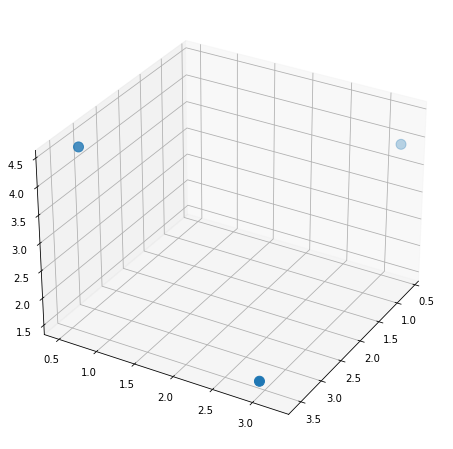

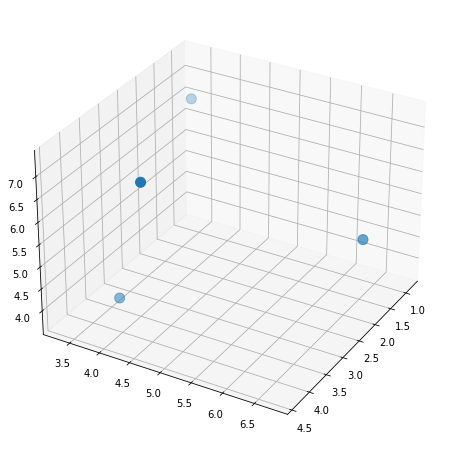

(None, None)

In [30]:
X_min3 = X_min_N[1].reshape(-1,3)
X_min4 = X_min_N[2].reshape(-1,3)
def plot_3d(X, alpha=30, beta=30):
    """Displays X (3,N) positions of particles in 3D from angles alpha and beta."""
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection='3d' )
    ax.scatter(X[:,0],X[:,1],X[:,2],marker = 'o', s = 100)
    ax.view_init(alpha, beta)
    plt.show()
plot_3d(X_min3),plot_3d(X_min4)

# i. BFGS with golden section line search

In [31]:
def BFGS_ls(f, gradf, X, tol = 1e-6, max_iter = 10000):
    """Slight modification of BFGS adding golden section line search befor updating the B matrix.
    Returns:\nMinimum X\nNumber of function calls N_calls\n Boolean variable converged."""
    X = np.copy(X)
    N_calls, converged = 0, True
    dfX0 = gradf(X)
    B = np.eye(len(X))
    while(abs(la.norm(dfX0))>tol and N_calls<=max_iter):
        N_calls+=2
        dx = la.solve(B,-dfX0)
        F_red_line = lambda s: f(X+s*dx)
        alpha, add_calls = golden_section_min(F_red_line, -1, 1, tol = 1e-3)
        N_calls += add_calls
        dx = alpha*dx
        X = X + dx
        dfX = gradf(X)
        dy = dfX-dfX0
        dfX0 = dfX
        B += (np.outer(dy,dy)/(dy@dx) - np.outer(B@dx, B@dx)/(dx@(B@dx)))
    if N_calls>=max_iter:
        converged = False
    return X, N_calls, converged

In [32]:
X_min_N_ls, calls_N_ls, conv_N_ls, Distance_N_ls, vdw_N_ls, E_N_ls = [],[],[],[],[],[]
for i in range(8):
    X_min, calls, conv = BFGS_ls(V_flat, dV_flat, ArStarts[i][1], tol = 1e-10, max_iter = 10000)
    X_min_N_ls.append(X_min), calls_N_ls.append(calls)
    conv_N_ls.append(conv), Distance_N_ls.append(d)
    vdw_N_ls.append(num_vdw(X_min))
    E_N_ls.append(V_flat(X_min))
print("Energies: {}\nNumber of function calls = {}".format(E_N_ls, calls_N_ls))

Energies: [-0.9970000000000002, -2.9909999999999997, -5.982, -9.076540858460433, -12.266018746991987, -15.486460874411147, -18.72187354958683, -22.01505806679415]
Number of function calls = [420, 644, 812, 1792, 2912, 6496, 5236, 2352]


| Number of particles | 2 | 3 | 4  | 5 | 6 | 7 | 8 | 9 |
|---------------------|---|---|----|---|---|---|---|---|
| Number of VdW bonds | 2 | 6 | 12 | 18 | 24 | 30 | 36 | 38 |

The number of steps needed to converge increased but now the algorithm results in VdW bonds up to N=9. The number of VdW bonds did not change for N=2, N=3, N=4.

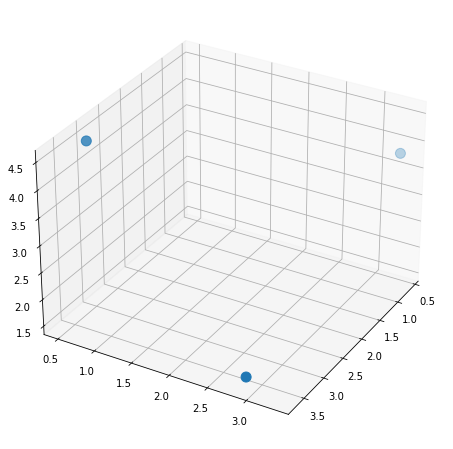

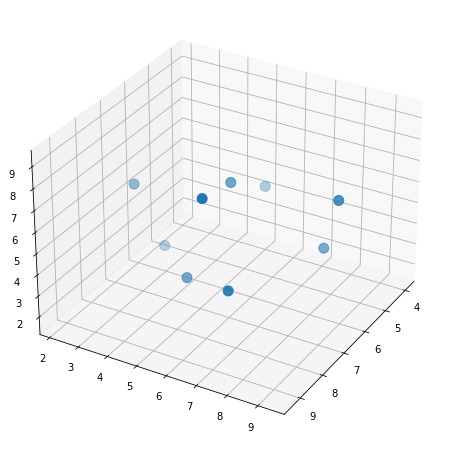

(None, None)

In [33]:
X_min3_ls = X_min_N_ls[1].reshape(-1,3)
X_min9_ls = X_min_N_ls[-1].reshape(-1,3)
plot_3d(X_min3_ls), plot_3d(X_min9_ls)

# k. Simulated annealing 

In [34]:
def sim_annealing(F, X0, T = 10000, max_iter = 1e6, cooling_factor = .999, 
                  step_factor = .001):
    """Simulated annealing for finding minimum of function F.\nReturns:
    Minimum X\nEnergies at each step E_all, len(E_all)+1=number of function calls."""
    E_all = []
    E0 = F(X0)
    while(len(E_all)<max_iter and T>1e-6):
        E_all.append(E0)
        X = X0+(np.random.rand(len(X0))-.5)*step_factor
        E = F(X)
        DE = (E-E0)/T
        if DE>1e6:
            DE = 1e6
        if np.exp(-DE)>=np.random.rand():
            X0 = X
            E0 = E
        T = T/(1+cooling_factor*T)
    return X0, E_all

In [35]:
X_min5_sa, E_all5_sa = sim_annealing(V_flat, ArStarts[3][1], T = 1e5, max_iter = 15e3, 
                                cooling_factor = (1-1e-6), step_factor = .01)
vdw5_sa = num_vdw(X_min5_sa)
vdw5_sa, len(E_all5_sa)

(18, 15000)

In [36]:
X_min9_sa, E_all9_sa= sim_annealing(V_flat, ArStarts[-3][1], T = 1e4, max_iter = 30e3, 
                                cooling_factor = (1-1e-6),step_factor = .03)
vdw9_sa = num_vdw(X_min9_sa)
vdw9_sa, len(E_all9_sa)

(42, 30000)

In [37]:
X_min20_sa, E_all20_sa= sim_annealing(V_flat, ArStarts[-2][1], T = 1e5, max_iter = 80e3, 
                                cooling_factor = (1-1e-7), step_factor = .01)
vdw20_sa = num_vdw(X_min20_sa)
vdw20_sa, len(E_all20_sa)

(66, 80000)

The dampened BFGS converges faster. However simulated annealing gives on average more Van der Waals bonds.

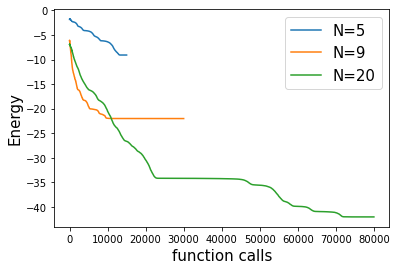

In [38]:
y1, y2, y3 = E_all5_sa, E_all9_sa, E_all20_sa
x1, x2 = np.arange(len(y1)), np.arange(len(y2))
x3 = np.arange(len(y3))
plot_func(x1 = x1 ,y1=y1, label1 = "N=5", ylabel = "Energy", 
          xlabel='function calls', plot2 = True, x2 = x2, y2 = y2, 
          label2 = "N=9", label3 = "N=20", plot3= True, x3 = x3, 
          y3 = y3, legend = True)

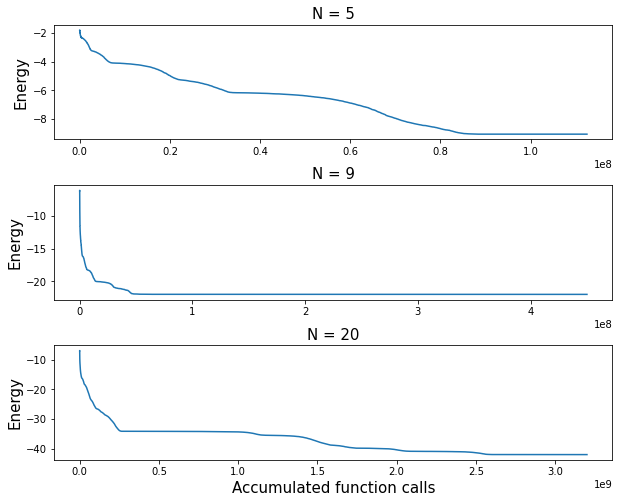

In [39]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
ax[0].plot(np.cumsum(x1),y1), ax[1].plot(np.cumsum(x2),y2)
ax[2].plot(np.cumsum(np.double(x3)),y3)
ax[2].set_xlabel("Accumulated function calls", fontsize = 15)
num = [5,9,20]

for i in range(3):
    ax[i].set_ylabel("Energy", fontsize = 15)
    ax[i].set_title("N = {}".format(num[i]), fontsize = 15)
plt.subplots_adjust(hspace=0.4)
plt.show()

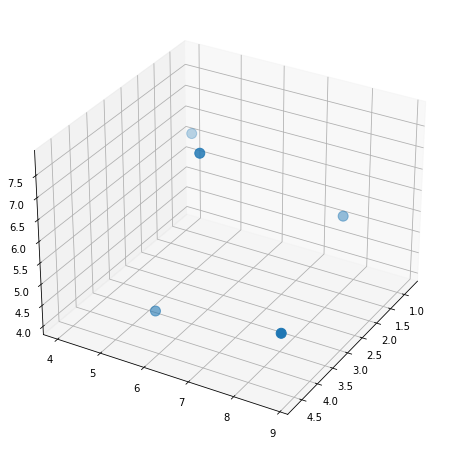

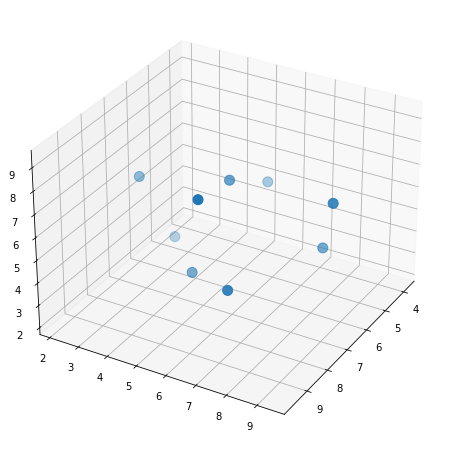

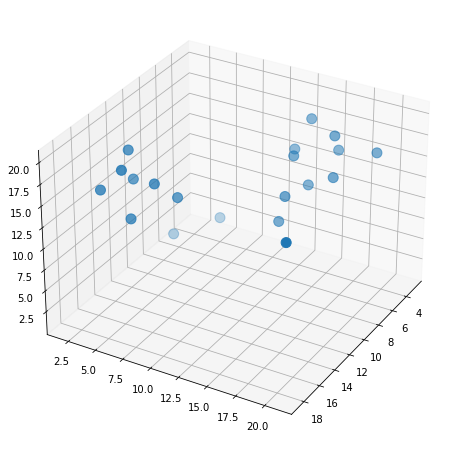

(None, None, None)

In [40]:
X_min5_sa = X_min5_sa.reshape(-1,3)
X_min9_sa = X_min9_sa.reshape(-1,3)
X_min20_sa = X_min20_sa.reshape(-1,3)
plot_3d(X_min5_sa), plot_3d(X_min9_sa), plot_3d(X_min20_sa)